In [1]:
!wget http://cs-chan.com/source/Face_Dataset.zip

--2018-10-22 10:36:00--  http://cs-chan.com/source/Face_Dataset.zip
Resolving cs-chan.com (cs-chan.com)... 182.50.135.89
Connecting to cs-chan.com (cs-chan.com)|182.50.135.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5933858 (5.7M) [application/x-zip-compressed]
Saving to: ‘Face_Dataset.zip.1’

Face_Dataset.zip.1  100%[===================>]   5.66M   609KB/s    in 11s     

2018-10-22 10:36:11 (549 KB/s) - ‘Face_Dataset.zip.1’ saved [5933858/5933858]



Data Downloaded. Now Unzipiing the Pratheepan DataBase

In [2]:
!unzip Face_Dataset.zip

Archive:  Face_Dataset.zip
replace Ground_Truth/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
Importing Libraries

In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import glob

import logging

ModuleNotFoundError: No module named 'cv2'

Loading Images

In [0]:
im_list = []
for filename in glob.glob('Pratheepan_Dataset/FacePhoto/*.jpg'):
    img= cv2.imread(filename)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_list.append(img)

In [5]:
im_list[0].shape

(800, 548, 3)

In [0]:
def huelayer(img):
  img = cv2.GaussianBlur(img,(5,5),0)
  imghsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  h,s,v = imghsv[:,:,0], imghsv[:,:,1],imghsv[:,:,2]
  r,g,b = img[:,:,0], img[:,:,1],img[:,:,2]
  
  #=== RGB Thresholding ===========
  print(r.dtype)
  r = cv2.threshold 
  skinrgb = cv2.bitwise_and(r , g,mask = None) 
 
  return skinrgb


In [9]:
img= im_list[1]
plt.imshow(huelayer(img))
plt.show()
# cv.waitKey(1000)

uint8


TypeError: ignored

In [0]:
def get_hsv_mask(img, debug=False):
    logger.debug('getting hsv mask')
    lower_thresh = np.array([0, 50, 0], dtype=np.uint8)
    upper_thresh = np.array([120, 150, 255], dtype=np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
    logger.debug('getting rgb mask')    
    lower_thresh = np.array([45, 52, 108], dtype=np.uint8)
    upper_thresh = np.array([255, 255, 255], dtype=np.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((np.max(img, axis=2) - np.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = np.bitwise_and(np.uint64(mask_a), np.uint64(mask_b))
    msk_rgb = np.bitwise_and(np.uint64(mask_c), np.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
  
    logger.debug('getting ycrcb mask')
  
    lower_thresh = np.array([90, 100, 130], dtype=np.uint8)
    upper_thresh = np.array([230, 120, 180], dtype=np.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
  
    kernel = np.ones((50, 50), np.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = np.array(cv2.bitwise_not(dst), dtype=np.uint8)

    if debug:
        scripts.display('not skin', free)
        scripts.display('grabcut input', mask)

    grab_mask = np.zeros(mask.shape, dtype=np.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if np.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8)
        else:
            logger.warning('img_col is empty')

    return mask


def closing(mask):
  
    logger.debug("closing mask of shape {0}".format(mask.shape))
  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def process(img, thresh=0.5, debug=False):
  
    logger.debug("processing image of shape {0}".format(img.shape))
    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)

    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks
#     mask = mask_rgb
    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * np.sum(mask) / mask.size)))

    mask = mask.astype(np.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    return mask



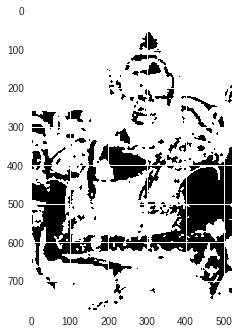

In [11]:
logger = logging.getLogger('main')
plt.imshow(process(im_list[3]))
plt.show()

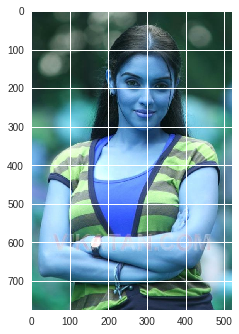

In [12]:
plt.imshow((im_list[3]))
plt.show()